# Collaboration and Competition


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
from numpy.random import choice
import copy

## Load the environment

In [3]:
env = UnityEnvironment(file_name="envs/tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
# env.close()

## Define Actor Class

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, nA, nS, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.dense1 = nn.Linear(nS, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dense2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dense3 = nn.Linear(128, nA)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.dense1.weight.data.uniform_(*hidden_init(self.dense1))
        self.dense2.weight.data.uniform_(*hidden_init(self.dense2))
        self.dense3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, training=True):
#         x = F.leaky_relu(self.bn1(self.dense1(state)))
#         x = F.leaky_relu(self.bn2(self.dense2(x)))
#         x = F.tanh(self.dense3(x))

        x = F.leaky_relu(self.dense1(state))
        x = F.leaky_relu(self.dense2(x))
        x = F.tanh(self.dense3(x))
        return x

## Define Critic Class

In [7]:
class Critic(nn.Module):
    def __init__(self, nA, nS, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.dense1 = nn.Linear(nS, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dense2 = nn.Linear(nA+256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dense3 = nn.Linear(128, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.dense1.weight.data.uniform_(*hidden_init(self.dense1))
        self.dense2.weight.data.uniform_(*hidden_init(self.dense2))
        self.dense3.weight.data.uniform_(-4e-3, 4e-3)
    
    def forward(self, state, action, training=True):
#         x = F.leaky_relu(self.bn1(self.dense1(state))).float()
#         x = F.leaky_relu(self.bn2(self.dense2(torch.cat((x, action.float()), 1))))
#         x = F.tanh(self.dense3(x))

        x = F.leaky_relu(self.dense1(state))
        x = torch.cat((x, action), 1)
        x = F.leaky_relu(self.dense2(x))
        x = self.dense3(x)
        
        return x

## Define Buffer Class

In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, nA, nS, seed, prioritized=False, e=0.1):
        self.e=e
        self.nA = nA
        self.nS = nS
        self.memory = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.prioritized = prioritized
        self.seed = random.seed(seed)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self, a=0):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.stack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

## Define OUNoise Class

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

## HyperParameters

In [15]:
BUFFER_SIZE = int(1e6)  
BATCH_SIZE = 256   
GAMMA = 0.99       
TAU = 2e-3      
LR_ACTOR = 1.0e-3     
LR_CRITIC = 1.0e-3     
WEIGHT_DECAY = 0
UPDATE_EVERY = 10
UPDATE_NUM = 2
EPSILON = 1.0
EPS_DECAY = 1.0e-5
EPS_END=0.02
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define Agent Class
The difference between ddpg is when the agent learns, its critic has to take into account the states from other agents and their actions.

In [16]:
class Agent():
    def __init__(self, nA, nS, nAgents, idxAgent, room, seed, prioritized=False):
        self.prioritized = prioritized
        self.state_size = nS
        self.action_size = nA
        self.idxAgent = idxAgent
        self.room = room
        self.nAgents = nAgents
        
        self.critic_local = Critic(nA*nAgents, nS*nAgents, seed).to(device)
        self.critic_target = Critic(nA*nAgents, nS*nAgents, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.actor_local = Actor(nA, nS, seed).to(device)
        self.actor_target = Actor(nA, nS, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        self.t_step = 0
        self.ouNoise = OUNoise(nA, seed)
        
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, nA, nS, seed, prioritized=False, e=0.1)
        self.epsilon = EPSILON
        
    def step(self, states, actions, rewards, next_states, dones, a=0, b=1):
        tdE = 1.0
#         for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
#             self.memory.add(state, action, reward, next_state, done, tdE)
        self.memory.add(states, actions, rewards, next_states, dones)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        

        if(self.t_step == 0):
            if(len(self.memory) > BATCH_SIZE):
                for i in range(UPDATE_NUM):
                    experiences = self.memory.sample(a)
                    self.learn(experiences, GAMMA, b)
                
    def act(self, state, training=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action_values = self.actor_local(state)
        self.actor_local.train()
        av2 =action_values.cpu().numpy()
        if(training and (random.random() < self.epsilon)):
            self.epsilon -= EPS_DECAY
            if(self.epsilon < EPS_END):
                self.epsilon = EPS_END
            av2 += self.ouNoise.sample()
        return(np.clip(av2, -1, 1))
        
    
    def learn(self, experiences, gamma, b):
        states, actions, rewards, next_states, dones = experiences
        next_actions = self.actor_target(next_states[:,self.idxAgent])
        next_actions = self.room.getNextActionsTarget(next_states)
        
        with torch.no_grad():
            next_Qvalues = self.critic_target(next_states.view(BATCH_SIZE,self.nAgents*self.state_size), next_actions)
        
#         print('original')
#         print(next_states[:2])
#         print('new view')
#         print(next_states.view(BATCH_SIZE,self.nAgents*self.state_size)[:2])
    
#         print('next actions')
#         print(next_actions.shape)
#         print('nextQvalues')
#         print(next_Qvalues.shape)
        
#         print('dones')
#         print(dones.unsqueeze(1)[:,0].shape)
#         print(dones)
#         print('rewards')
#         print(rewards.unsqueeze(1).shape)
        
        
        Qtargets = rewards.unsqueeze(1) + (GAMMA*next_Qvalues * (1-dones.unsqueeze(1)[:,0]))
#         print('Qtargets')
#         print(Qtargets.shape)
        
        
        
        Qexpected = self.critic_local(states.view(BATCH_SIZE,self.nAgents*self.state_size), actions.view(BATCH_SIZE, self.nAgents*self.action_size))
#         print('Qexpected')
#         print(Qexpected.shape)
        
        
        loss_critic = F.mse_loss(Qexpected, Qtargets)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0)
        self.critic_optimizer.step()
        
        actions_pred = self.actor_local(states[:,self.idxAgent])
        actions_pred = self.room.getActionsLocal(states)
        loss_actor = -self.critic_local(states.view(BATCH_SIZE,self.nAgents*self.state_size), actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.critic_local, self.critic_target, TAU)  
        self.soft_update(self.actor_local, self.actor_target, TAU)  
        
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def reset(self):
        self.ouNoise.reset()
        

## Define Agent Controller
I created this class to manage the multiple agents and to provide the necessary information for training

In [17]:
class AgentWaitingRoom():
    def __init__(self, nAgents, nS, nA, seed=0):
        self.nAgents = nAgents
        self.nA = nA
        self.agents = [Agent(nA, nS, nAgents, agent, self, seed) for agent in range(nAgents)]
    def train(self, n_episodes=25000, max_t=2000, print_every=100):
        scores_all = [[] for i in range(self.nAgents)]
        scores_avg_all=[[] for i in range(self.nAgents)]
        score_windows = [deque(maxlen=100) for i in range(self.nAgents)]
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]
            for agent in self.agents:
                agent.reset()
            states = env_info.vector_observations
            scores = np.zeros(self.nAgents)
            
            for t in range(max_t):
                actions = [agent.act(states[agent.idxAgent]) for agent in self.agents]
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                scores += env_info.rewards
                for agent in self.agents:
                    agent.step(states, actions, env_info.rewards[agent.idxAgent], next_states, dones[agent.idxAgent])
                states = next_states
                if(np.any(dones)):
                    break
                    
            for agent in self.agents:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(agent.idxAgent))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_critic_{}.pth'.format(agent.idxAgent))
                
            message = '\rEpisode {}'.format(i_episode)
            for i, score in enumerate(scores):
                score_windows[i].append(score)
                scores_all[i].append(score)
                scores_avg_all[i].append(round(np.mean(score_windows[i])))
                message = message + '\tAverage Score: '+str(i)+' '+str(round(np.mean(score_windows[i]), 3))
                if(round(np.mean(score_windows[i]), 3) > 0.5):
                    
                    print('reached average 100 past episode score greater than 0.5 with agent {} at episode {}'.format(i, i_episode))
                    return scores_all, scores_avg_all
                
            
            print(message, end="")
            
            
                
            if i_episode % print_every == 0:
                print(message)
        return scores_all, scores_avg_all
    
    
    def getNextActionsTarget(self,next_states):
        nextActions = []
        for i, agent in enumerate(self.agents):
#             agent.actor_target.eval()
#             with torch.no_grad():
#                 next_actions = agent.actor_target(next_states[:,i])
#                 nextActions.append(next_actions)
#             agent.actor_target.train()
            
            next_actions = agent.actor_target(next_states[:,i])
            nextActions.append(next_actions)
            
        return torch.stack(nextActions, dim=1, out=None).view(BATCH_SIZE, self.nA*self.nAgents)

    def getActionsLocal(self, states):
        Actions = []
        for i, agent in enumerate(self.agents):
#             agent.actor_local.eval()
#             with torch.no_grad():
#                 actions = agent.actor_local(states[:,i])
#                 Actions.append(actions)
#             agent.actor_local.train()    
            
            actions = agent.actor_local(states[:,i])
            Actions.append(actions)
            
        return torch.stack(Actions, dim=1, out=None).view(BATCH_SIZE, self.nA*self.nAgents)
            
                
        

In [20]:
room = AgentWaitingRoom(2, state_size, action_size)

## Training time

In [21]:
all_scores, all_avg_scores = room.train()

Episode 17	Average Score: 0 -0.005	Average Score: 1 0.001

c:\users\jl\miniconda3\envs\mlagents\lib\site-packages\ipykernel_launcher.py:92: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score: 0 -0.004	Average Score: 1 -0.004
Episode 200	Average Score: 0 -0.001	Average Score: 1 -0.005
Episode 300	Average Score: 0 -0.004	Average Score: 1 -0.006
Episode 400	Average Score: 0 -0.004	Average Score: 1 -0.005
Episode 500	Average Score: 0 -0.005	Average Score: 1 -0.004
Episode 600	Average Score: 0 -0.004	Average Score: 1 -0.004
Episode 700	Average Score: 0 0.002	Average Score: 1 -0.0034
Episode 800	Average Score: 0 0.02	Average Score: 1 -0.0033
Episode 900	Average Score: 0 0.003	Average Score: 1 -0.005
Episode 1000	Average Score: 0 -0.005	Average Score: 1 -0.005
Episode 1100	Average Score: 0 -0.005	Average Score: 1 0.0091
Episode 1200	Average Score: 0 0.021	Average Score: 1 0.0239
Episode 1300	Average Score: 0 0.012	Average Score: 1 0.026
Episode 1400	Average Score: 0 0.025	Average Score: 1 0.025
Episode 1500	Average Score: 0 0.039	Average Score: 1 0.011
Episode 1600	Average Score: 0 0.046	Average Score: 1 -0.006
Episode 1700	Average Score: 0 0.033	Average

# Score results

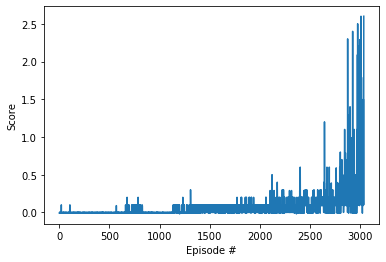

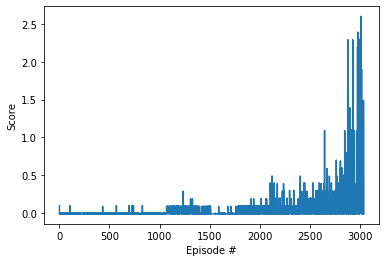

In [22]:
for score_i in all_scores:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(score_i)+1), score_i)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [31]:
np.mean(all_scores[0][-100:])

0.5104000077396631

In [33]:
np.mean(all_scores[1][-100:])

0.4817000074312091

The first agent reached a mean score of 0.51 from the last 100 episodes

## Test agents

In [46]:
for i in range(1, 5):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = [agent.act(states[agent.idxAgent]) for agent in room.agents]
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if(np.any(dones)):
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.400000035762787
Score (max over agents) from episode 3: 2.4900000374764204
Score (max over agents) from episode 4: 2.2000000327825546


In [ ]:
env.close()

# Run the trained agent

In [65]:
env = UnityEnvironment(file_name="envs/tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [81]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.66271734 -1.5
 -0.          0.          6.04292488  5.99607611 -0.          0.        ]


In [82]:

room2 = AgentWaitingRoom(2, state_size, action_size)

for i, agent in enumerate(room2.agents):
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_{}.pth'.format(i)))

In [83]:
for i in range(1, 4):                                     
    env_info = env.reset(train_mode=False)[brain_name]   
    states = env_info.vector_observations                 
    scores = np.zeros(num_agents)                         
    while True:
        actions = [agent.act(states[agent.idxAgent], False) for agent in room2.agents]
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if(np.any(dones)):
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
Score (max over agents) from episode 3: 2.600000038743019


In [84]:
env.close()